# Importation

In [14]:
import os
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, RidgeClassifier, RidgeClassifierCV
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
from tqdm.notebook import tqdm
tqdm.pandas

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

# Load data

In [3]:
employee = pd.read_csv('C:/py/data/attrition/employee.csv')
employee = employee.drop(["EmployeeCount", "EmployeeNumber", "Over18", "StandardHours"], axis = 1)

# Preprocessing

In [4]:
employee.columns = employee.columns.str.lower()
employee["overtime"] = employee["overtime"].replace("Yes", 1)
employee["overtime"] = employee["overtime"].replace("No", 0)
employee["gender"] = employee["gender"].replace("Male", 1)
employee["gender"] = employee["gender"].replace("Female", 0)

employee = employee.rename(columns = {"attrition" : "y"})

employee["y"] = employee["y"].replace("Yes", 1)
employee["y"] = employee["y"].replace("No", 0)

cat = [var for var in employee.columns if var not in employee.describe().columns.tolist()]

for var in cat:
    
    employee[var] = employee[var].str.lower()
    employee[var] = employee[var].str.replace(' ', '_').astype(str)
    employee[var] = employee[var].str.replace('-', '_').astype(str)
    employee[var] = employee[var].str.replace('&', '_').astype(str)
    employee[var] = employee[var].str.replace('___', '_').astype(str)

y = employee["y"]
X = employee.drop(['y'], axis = 1)

for var in cat :
    
    for val in X[var].value_counts().index.tolist():
        
        X[var] = X[var].replace(val, var+"_"+val)
        
for var in cat :

    dummies = pd.get_dummies(X[var])
    X = X.drop(var,axis = 1)
    X = X.join(dummies)
    
X.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,...,jobrole_laboratory_technician,jobrole_manager,jobrole_manufacturing_director,jobrole_research_director,jobrole_research_scientist,jobrole_sales_executive,jobrole_sales_representative,maritalstatus_divorced,maritalstatus_married,maritalstatus_single
0,41,1102,1,2,2,0,94,3,2,4,...,0,0,0,0,0,1,0,0,0,1
1,49,279,8,1,3,1,61,2,2,2,...,0,0,0,0,1,0,0,0,1,0
2,37,1373,2,2,4,1,92,2,1,3,...,1,0,0,0,0,0,0,0,0,1
3,33,1392,3,4,4,0,56,3,1,3,...,0,0,0,0,1,0,0,0,1,0
4,27,591,2,1,1,1,40,3,1,2,...,1,0,0,0,0,0,0,0,1,0


In [5]:
augmentation =[ ]
for var in X.columns :
    if X[var].unique().tolist() == [0,1] :
        pass
    elif X[var].unique().tolist() ==[1,0]:
        pass
    else :
        augmentation.append(var)

In [6]:
X_nl = X.copy()

for var in augmentation :
    
    X_nl[var+'_squared'] = X_nl[var]**2
    X_nl[var+'_cube'] = X_nl[var]**3

# List of variables selected with Autometrics

In [7]:
var_selected_autometrics = X_nl[["age", "environmentsatisfaction", "joblevel", "overtime", "stockoptionlevel", 
   "businesstravel_travel_frequently", "age_squared", 
  "joblevel_squared", "department_research_development", "distancefromhome",
  "monthlyrate", "performancerating", "yearswithcurrmanager", "jobinvolvement_cube", 
     "jobsatisfaction_squared", "numcompaniesworked_squared", "performancerating_squared", "stockoptionlevel_squared",
     "worklifebalance_squared", "worklifebalance_cube", "yearswithcurrmanager_squared", "yearswithcurrmanager_cube"]]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(var_selected_autometrics, y, test_size = 0.2, random_state = 42)

# Tests of the variables selected to predict attrition

In [27]:
def recall_precision(y_test,y_pred,model):
    precision, recall, thresholds = precision_recall_curve(y_test,y_pred)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    fscore[np.isnan(fscore)] = 0
    #print(fscore)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    optimal_threshold = thresholds[ix]

    # plot the recall precision curve for the model
    plt.plot(recall, precision, marker='.', label=model)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()
    
    print("\nTEST")
    print('Best Threshold=%f, F-Score=%.3f' % (optimal_threshold, fscore[ix]))
    y_pred2= np.where(y_pred <= optimal_threshold , 0, 1)
    cm = confusion_matrix(y_test, y_pred2)
    print("Confusion matrix \n" , cm)
    precision = cm[1,1]/sum(cm[:,1])
    print("\nPrecision : " + str(precision))
    recall = cm[1,1]/sum(cm[1,:])
    print("Recall : " + str(recall))
    f1 = 2*((precision*recall)/(precision+recall))
    print("F1 : " + str(f1))
    
    residual = (y_test - y_pred)
    print("\n Residuals distribution : \n", residual.describe())
    
    return optimal_threshold

In [28]:
model = LinearRegression().fit(X_train, y_train)
y_ols = model.predict(X_test)

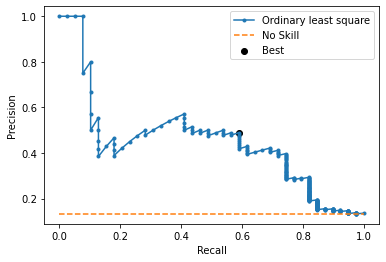


TEST
Best Threshold=0.332788, F-Score=0.535
Confusion matrix 
 [[231  24]
 [ 17  22]]

Precision : 0.4782608695652174
Recall : 0.5641025641025641
F1 : 0.5176470588235293

 Residuals distribution : 
 count    294.000000
mean      -0.009872
std        0.324088
min       -0.589778
25%       -0.215902
50%       -0.077945
75%        0.072570
max        1.188851
Name: y, dtype: float64


In [29]:
t1 = recall_precision(y_test,y_ols,'Ordinary least square')

In [35]:
y_olsf1 = np.where(y_ols <= t1 , 0, 1)

# SVM 

In [17]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [31]:
svc = SVC(kernel = 'sigmoid',
           C = 0.1,
           gamma = 0.01,
           random_state = 0, probability = True).fit(X_train, y_train)
y_svm = svc.predict_proba(X_test)[:,1]

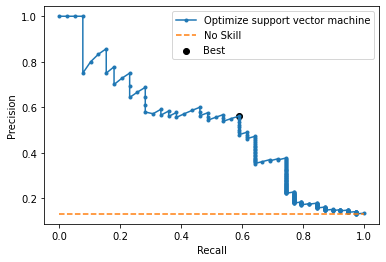


TEST
Best Threshold=0.345621, F-Score=0.575
Confusion matrix 
 [[237  18]
 [ 17  22]]

Precision : 0.55
Recall : 0.5641025641025641
F1 : 0.5569620253164557

 Residuals distribution : 
 count    294.000000
mean      -0.016612
std        0.298803
min       -0.763221
25%       -0.125255
50%       -0.047341
75%       -0.012009
max        0.997531
Name: y, dtype: float64


In [32]:
t4 = recall_precision(y_test,y_svm,'Optimize support vector machine')

In [33]:
y_svmf1 = np.where(y_svm <= t4 , 0, 1)

In [36]:
 f_score = pd.DataFrame({
    'Algorithm' : ['OLS','SVM'],
    'y_pred' : [y_olsf1,y_svmf1]
})
f1_list = []
for index, row in f_score.iterrows():
    f1 = f1_score(y_test, row['y_pred'], average='binary')
    f1_list.append(f1)
acc_list = []
for index, row in f_score.iterrows():
    acc = accuracy_score(y_test, row['y_pred'])
    acc_list.append(acc)
    
f_score['f1']=f1_list
f_score['acc']=acc_list
f_score = f_score.drop(['y_pred'], axis=1)
f_score.sort_values(by=['f1'],ascending=False)

,Algorithm,f1,acc
1,SVM,0.556962,0.880952
0,OLS,0.517647,0.860544
